<a href="https://colab.research.google.com/github/Shreenidhi-Kovai-Sivabalan/Accurate-Energy-Demand-Prediction/blob/main/IntermediateModels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Appendix A
# Accurate Energy Demand Prediction for Smart Cities using Deep Learning
Project Code

Shreenidhi Kovai Sivabalan

Date of Submission: Oct 1, 2025

# A4. Intermediate Models

In [ ]:
# Mounting to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Importing necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
import xgboost as xgb
import time

## Data Preparation

In [ ]:
# Importing the datasets

filepath1 = '/content/drive/MyDrive/dissertation/data/data_minute.csv'
df_minute = pd.read_csv(filepath1)
df_minute.set_index('Datetime', inplace=True)

In [ ]:
filepath2 = '/content/drive/MyDrive/dissertation/data/data_hourly.csv'
df_hourly = pd.read_csv(filepath2)
df_hourly.set_index('Datetime', inplace=True)

In [ ]:
filepath3 = '/content/drive/MyDrive/dissertation/data/data_daily.csv'
df_daily = pd.read_csv(filepath3)
df_daily.set_index('Datetime', inplace=True)

Functions for evaluating model performance

In [ ]:
def evaluate_model(y_true, y_pred, model_name, freq, execution_time):
  mse = mean_squared_error(y_true, y_pred)
  mae = mean_absolute_error(y_true, y_pred)
  rmse = np.sqrt(mse)
  r2 = r2_score(y_true, y_pred)
  print(f"\n{model_name} ({freq}) Results:")
  print(f"MSE: {mse:.4f}")
  print(f"MAE: {mae:.4f}")
  print(f"RMSE: {rmse:.4f}")
  print(f"R2 Score: {r2:.4f}")
  print(f"Execution Time: {execution_time:.4f} seconds")
  return {"Model": model_name, "Frequency": freq, "MSE": mse, "MAE": mae, "RMSE": rmse, "R2": r2, "Execution Time": execution_time}

In [ ]:
# Function for plotting actual vs. predicted
def plot_actual_vs_pred(y_true, y_pred, freq):
  plt.figure(figsize=(12, 6))
  plt.plot(y_true.index, y_true, label="Actual", color='black')
  plt.plot(y_test.index, y_pred, label="Predicted", color='green', alpha=0.5)
  plt.title(f"Energy Demand ({freq}): Actual Vs. Predicted")
  plt.xlabel("Time")
  plt.ylabel("Global Active Power")
  plt.legend()
  # Improve x-axis display
  plt.xticks(rotation=45)
  plt.gca().xaxis.set_major_locator(plt.MaxNLocator(nbins=10)) # Adjust number of ticks
  plt.tight_layout()
  plt.show()

In [ ]:
# Function for plotting residual distribution
def plot_residuals(y_true, y_pred, freq):
  residuals = y_true - y_pred.flatten()

  plt.figure(figsize=(12, 6))
  sns.histplot(residuals, kde=True, color='green', stat='density', bins=50)
  plt.title(f"Residual Distribution ({freq})")
  plt.xlabel("Prediction Error")
  plt.ylabel("Density")
  plt.legend()
  plt.show()

In [ ]:
# Function for plotting seasonal pattern comparison
# period = no. of steps in one daily/weekly cycle -> 60/1440 for minutes, 24/168 for hours, 7 for days
def plot_seasonal_patterns(y_true, y_pred, period, freq):
  if isinstance(y_pred, np.ndarray):
      y_pred = pd.Series(y_pred.flatten(), index=y_true.index)

  avg_true = [y_true[i::period].mean() for i in range(period)]
  avg_pred = [y_pred[i::period].mean() for i in range(period)]

  plt.figure(figsize=(12, 6))
  plt.plot(avg_true, label="Actual", color='black', marker='o')
  plt.plot(avg_pred, label="Predicted", color='blue', marker='x')
  plt.title(f"Average Seasonal Pattern ({freq} for {period} period)")
  plt.xlabel(f"Time within Cycle (Period = {period})")
  plt.ylabel("Global Active Power")
  plt.legend()
  # Improve x-axis display
  plt.xticks(np.arange(0, period, max(1, period // 10)))
  plt.tight_layout()
  plt.show()

In [ ]:
target = 'Global_active_power'
features_min = df_minute.columns.tolist()
features_min.remove(target)
X_min = df_minute[features_min]
y_min = df_minute[target]

features_hr = df_hourly.columns.tolist()
features_hr.remove(target)
X_hr = df_hourly[features_hr]
y_hr = df_hourly[target]

features_dy = df_daily.columns.tolist()
features_dy.remove(target)
X_dy = df_daily[features_dy]
y_dy = df_daily[target]

In [ ]:
split_idx1 = int(len(X_min) * 0.8)
X_min_train, X_min_test = X_min.iloc[:split_idx1], X_min.iloc[split_idx1:]
y_min_train, y_min_test = y_min.iloc[:split_idx1], y_min.iloc[split_idx1:]

split_idx2 = int(len(X_hr) * 0.8)
X_hr_train, X_hr_test = X_hr.iloc[:split_idx2], X_hr.iloc[split_idx2:]
y_hr_train, y_hr_test = y_hr.iloc[:split_idx2], y_hr.iloc[split_idx2:]

split_idx3 = int(len(X_dy) * 0.8)
X_dy_train, X_dy_test = X_dy.iloc[:split_idx3], X_dy.iloc[split_idx3:]
y_dy_train, y_dy_test = y_dy.iloc[:split_idx3], y_dy.iloc[split_idx3:]

In [ ]:
# taking 10% of minute-level data as it is too large for hyperparameter tuning
# This is for hyperparameter tuning of MLP and XGBoost for minute-level data.

from sklearn.model_selection import train_test_split
X_min_sub, _, y_min_sub, _ = train_test_split(
    X_min, y_min, test_size=0.9, random_state=42
)
print(f"Subsample size for tuning: {X_min_sub.shape[0]} rows")

Subsample size for tuning: 206517 rows


In [ ]:
# train and test split for the models -- can  be switched between min, hr, dy
X_train, X_test = X_dy_train, X_dy_test
y_train, y_test = y_dy_train, y_dy_test
freq = "Daily"

In [ ]:
results = []

## Model Execution

MLP

In [ ]:
# MLP

# model building
mlp = MLPRegressor(
    hidden_layer_sizes=(100,50),
    activation='relu',
    solver='adam',
    max_iter=200,
    random_state=42
)

start_time = time.time()
mlp.fit(X_train, y_train)

MLPRegressor(hidden_layer_sizes=(100, 50), random_state=42)

In [ ]:
mlp_pred = mlp.predict(X_test) # evaluating on test set
end_time = time.time()
mlp_time = end_time - start_time

In [ ]:
results.append(evaluate_model(y_test, mlp_pred, 'MLP', freq, mlp_time))


MLP (Daily) Results:
MSE: 0.0169
MAE: 0.1045
RMSE: 0.1300
R2 Score: -0.6529
Execution Time: 1.4139 seconds


SVM

In [ ]:
# SVM

# building the SVM model
svm = SVR(kernel='rbf', C=100, epsilon=0.1)
start_time = time.time()
svm.fit(X_train, y_train)

SVR(C=100)

In [ ]:
svm_pred = svm.predict(X_test) # test set eval
end_time = time.time()
svm_time = end_time - start_time

In [ ]:
results.append(evaluate_model(y_test, svm_pred, 'SVM', freq, svm_time))


SVM (Daily) Results:
MSE: 0.0106
MAE: 0.0797
RMSE: 0.1029
R2 Score: -0.0360
Execution Time: 0.8636 seconds


XGBoost

In [ ]:
# XGBoost

xgb_reg = xgb.XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
start_time = time.time()
xgb_reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
xgb_pred = xgb_reg.predict(X_test) # evaluation on test set
end_time = time.time()
xgb_time = end_time - start_time

In [ ]:
results.append(evaluate_model(y_test, xgb_pred, 'XGBoost', freq, xgb_time))


XGBoost (Daily) Results:
MSE: 0.0000
MAE: 0.0042
RMSE: 0.0057
R2 Score: 0.9968
Execution Time: 1.1789 seconds


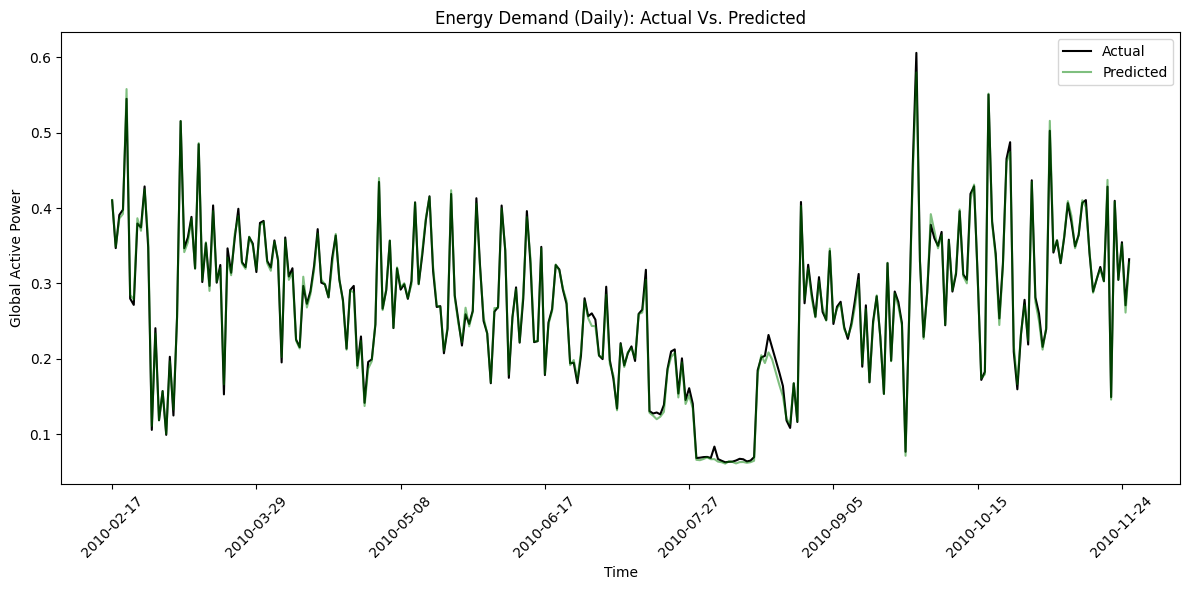

In [ ]:
plot_actual_vs_pred(y_test, xgb_pred, freq)

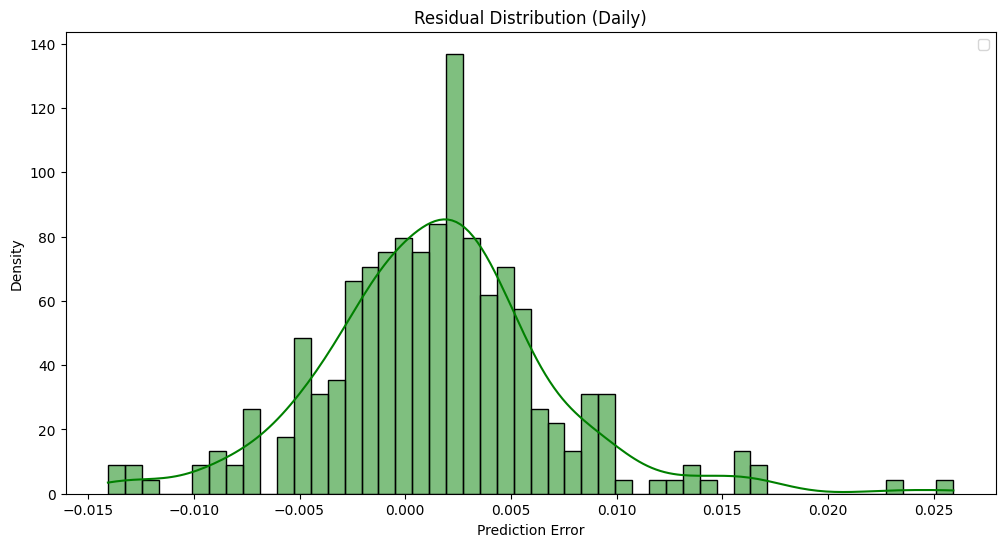

In [ ]:
plot_residuals(y_test, xgb_pred, freq)

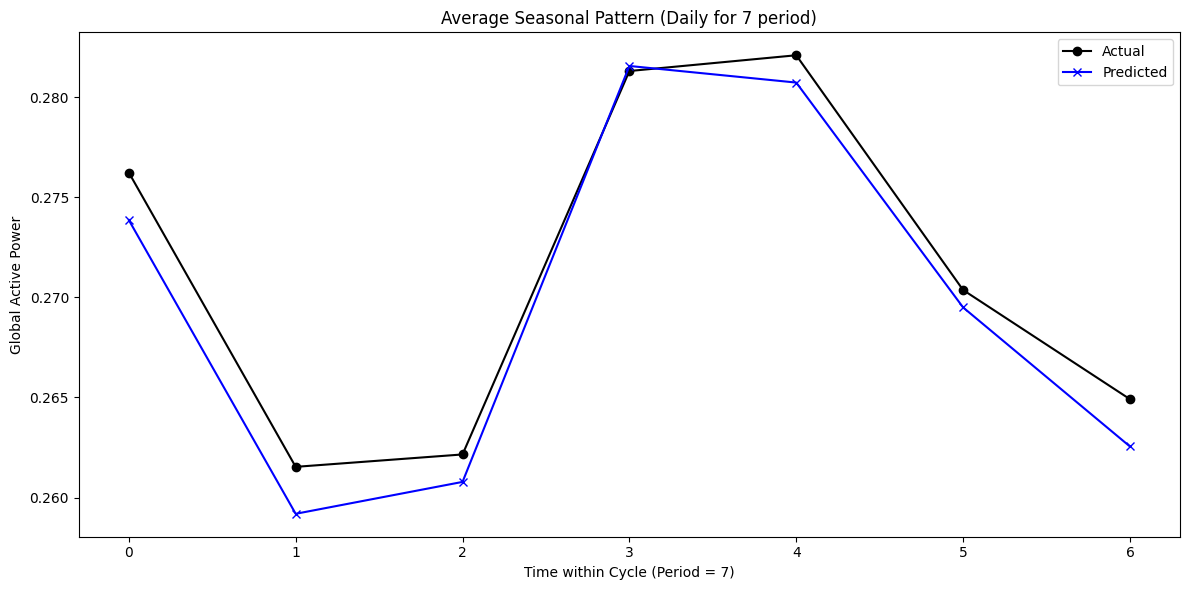

In [ ]:
plot_seasonal_patterns(y_test, xgb_pred, 7, freq)
#plot_seasonal_patterns(y_test, xgb_pred, 168, freq)

**Comparison of Results**

In [ ]:
results_df = pd.DataFrame(results)
print("Comparisons of Baseline Models: \n")
print(results_df)

Comparisons of Baseline Models: 

     Model Frequency       MSE       MAE      RMSE        R2  Execution Time
0      MLP    Minute  0.000148  0.009373  0.012168  0.995460     1283.377436
1  XGBoost    Minute  0.000045  0.004290  0.006675  0.998634        7.961397
2      MLP    Hourly  0.070648  0.261934  0.265797 -2.042489        3.097425
3      SVM    Hourly  0.009522  0.080302  0.097582  0.589918       21.117358
4  XGBoost    Hourly  0.000029  0.003286  0.005355  0.998765        1.761880
5      MLP     Daily  0.016902  0.104482  0.130006 -0.652857        1.413915
6      SVM     Daily  0.010594  0.079656  0.102927 -0.036011        0.863598
7  XGBoost     Daily  0.000033  0.004194  0.005705  0.996818        1.178888


# Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# RandomizedSearchCV was used as it is more computationally feasible compared to
#   exhaustive grid search.
# Especially given the scale of data used for this project, random search can help tune
#   more efficiently.

In [ ]:
results_tuned = []

In [ ]:
# Function for plotting search results across the parameters

def plot_search_results(search, title, param_x, metric="mean_test_score"):
    results = pd.DataFrame(search.cv_results_)
    plt.figure(figsize=(7,5))
    sns.lineplot(x=results["param_" + param_x], y=-results[metric])
    plt.title(f"{title}: {metric} vs {param_x}")
    plt.ylabel("MSE")
    plt.xlabel(param_x)
    plt.show()

MLP

In [ ]:
mlp_params = {
    "hidden_layer_sizes": [(50,), (100,), (100,50), (200,100,50)],
    "activation": ["relu", "tanh"],
    "alpha": [1e-5, 1e-4, 1e-3, 1e-2],
    "learning_rate_init": [0.001, 0.01, 0.05],
    "solver": ["adam"]
}

In [ ]:
# Cross validation cv=3 is used for all models
# This ensures that the model doesn't overfit or develop bias for the training data

mlp = MLPRegressor(max_iter=500, random_state=42)
mlp_search = RandomizedSearchCV(mlp, mlp_params, n_iter=10, cv=3, scoring="neg_mean_squared_error", n_jobs=-1, verbose=3)
start_time = time.time()
mlp_search.fit(X_train, y_train)
print("Best MLP params:", mlp_search.best_params_)
best_mlp = mlp_search.best_estimator_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best MLP params: {'solver': 'adam', 'learning_rate_init': 0.05, 'hidden_layer_sizes': (200, 100, 50), 'alpha': 0.0001, 'activation': 'tanh'}


In [ ]:
mlp_pred = best_mlp.predict(X_test)
end_time = time.time()
mlp_time = end_time - start_time
results_tuned.append(evaluate_model(y_test, mlp_pred, "MLP (Tuned)", freq, mlp_time))


MLP (Tuned) (Daily) Results:
MSE: 0.0117
MAE: 0.0843
RMSE: 0.1080
R2 Score: -0.1414
Execution Time: 4.5877 seconds


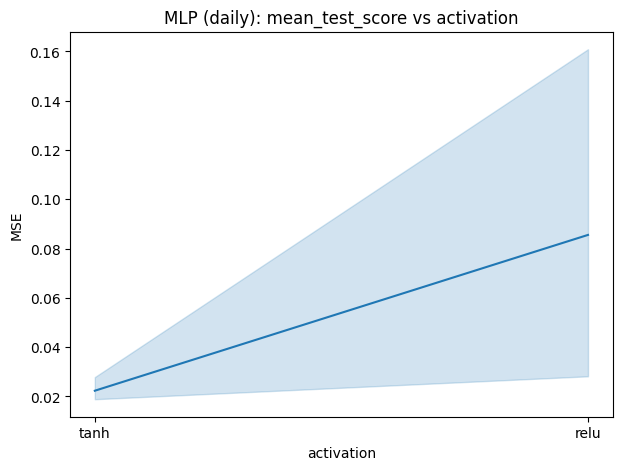

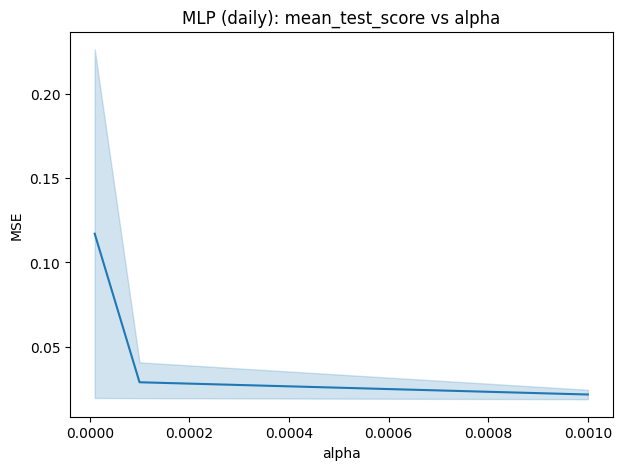

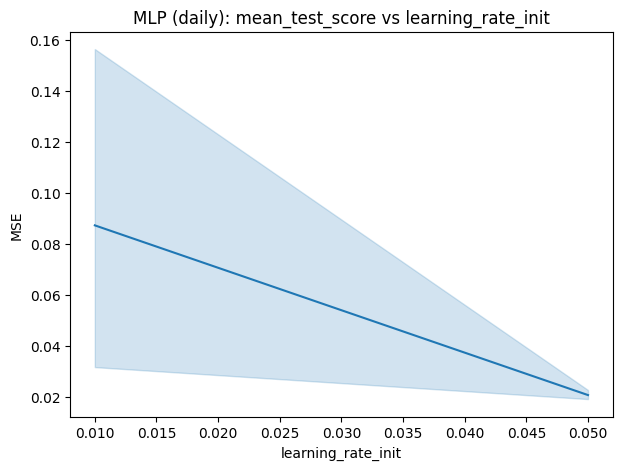

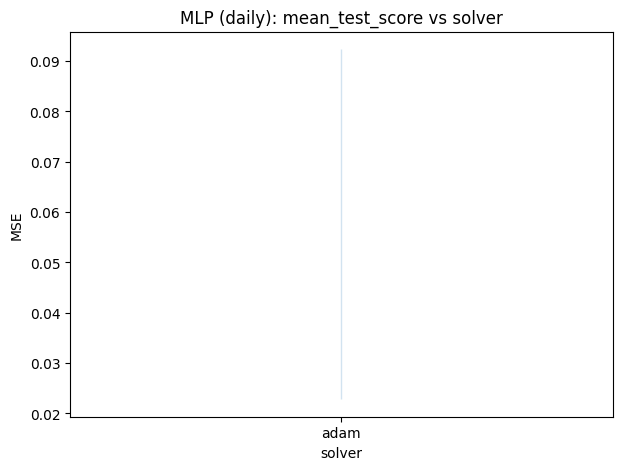

In [ ]:
for param in mlp_params.keys():
  if param != "hidden_layer_sizes": # Cannot plot hidden_layer_sizes directly
    plot_search_results(mlp_search, "MLP (daily)", param_x=param)

SVM

In [ ]:
svm_params = {
    "C": [0.1, 1, 10, 100],
    "epsilon": [0.01, 0.1, 0.2],
    "gamma": ["scale", 0.01, 0.1, 1]
}

In [ ]:
svm = SVR(kernel="rbf")
svm_search = RandomizedSearchCV(svm, svm_params, n_iter=10, cv=3, scoring="neg_mean_squared_error", n_jobs=-1, verbose=3)
start_time = time.time()
svm_search.fit(X_train, y_train)
print("Best SVM params:", svm_search.best_params_)
best_svm = svm_search.best_estimator_

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best SVM params: {'gamma': 0.1, 'epsilon': 0.01, 'C': 100}


In [ ]:
svm_pred = best_svm.predict(X_test)
end_time = time.time()
svm_time = end_time - start_time
results_tuned.append(evaluate_model(y_test, svm_pred, "SVM (Tuned)", freq, svm_time))


SVM (Tuned) (Daily) Results:
MSE: 0.0045
MAE: 0.0488
RMSE: 0.0669
R2 Score: 0.5627
Execution Time: 1.0763 seconds


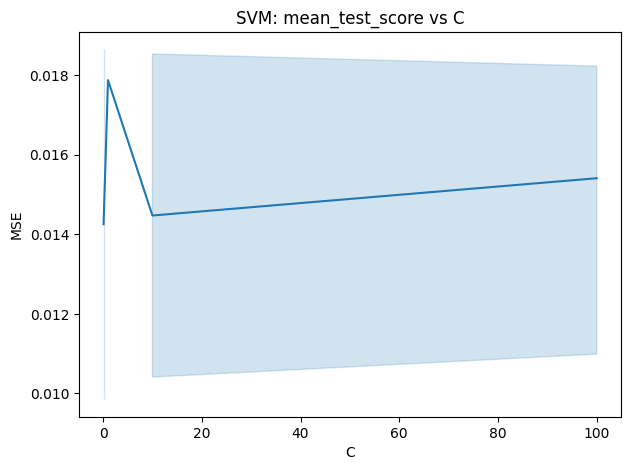

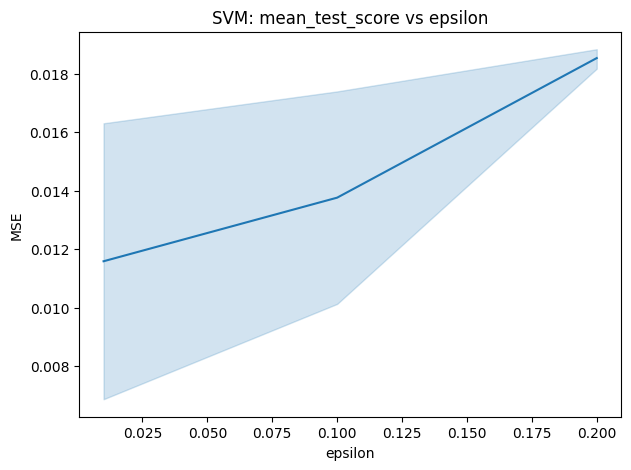

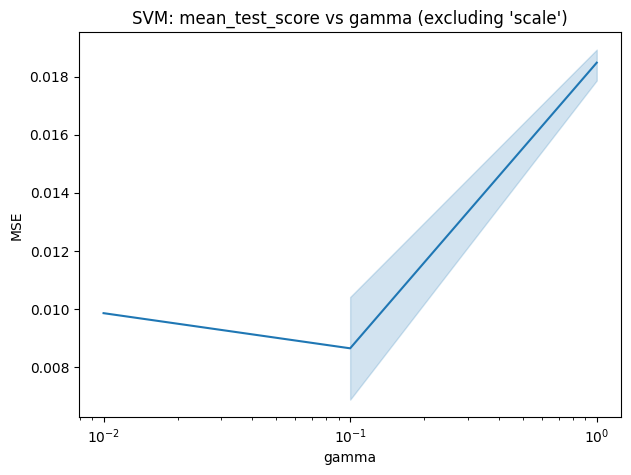

In [ ]:
# When coding these plots, there was an error regarding the parameters.
# to address this error, the built-in Gemini was used to rectify the error

for param in svm_params.keys():
  if param != "hidden_layer_sizes" and param != "gamma": # Cannot plot hidden_layer_sizes and gamma (with "scale") directly
    plot_search_results(svm_search, "SVM", param_x=param)

# Plot gamma separately, excluding 'scale'
gamma_results = pd.DataFrame(svm_search.cv_results_)
gamma_results_numeric = gamma_results[gamma_results["param_gamma"] != "scale"]

if not gamma_results_numeric.empty:
  plt.figure(figsize=(7,5))
  sns.lineplot(x=gamma_results_numeric["param_gamma"], y=-gamma_results_numeric["mean_test_score"])
  plt.title("SVM: mean_test_score vs gamma (excluding 'scale')")
  plt.ylabel("MSE")
  plt.xlabel("gamma")
  plt.xscale("log") # Use log scale for gamma if values span orders of magnitude
  plt.show()

XGBoost

In [ ]:
xgb_params = {
    "n_estimators": [100, 200, 500],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [3, 5, 7, 10],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "min_child_weight": [1, 3, 5],
    "gamma": [0, 0.1, 0.2]
}

In [ ]:
xgb_reg = xgb.XGBRegressor(random_state=42)
xgb_search = RandomizedSearchCV(xgb_reg, xgb_params, n_iter=15, cv=3, scoring="neg_mean_squared_error", n_jobs=-1)
start_time = time.time()
xgb_search.fit(X_train, y_train)
print("Best XGBoost params:", xgb_search.best_params_)
best_xgb = xgb_search.best_estimator_

Best XGBoost params: {'subsample': 0.6, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 1.0}


In [ ]:
xgb_pred = best_xgb.predict(X_test)
end_time = time.time()
xgb_time = end_time - start_time
results_tuned.append(evaluate_model(y_test, xgb_pred, "XGBoost (Tuned)", freq, xgb_time))


XGBoost (Tuned) (Daily) Results:
MSE: 0.0000
MAE: 0.0036
RMSE: 0.0047
R2 Score: 0.9979
Execution Time: 3.8050 seconds


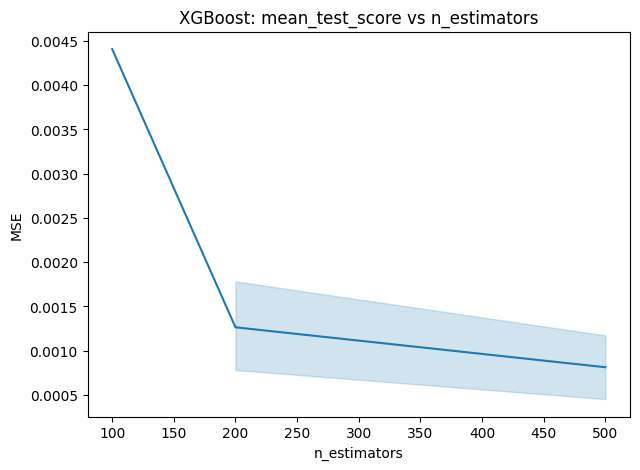

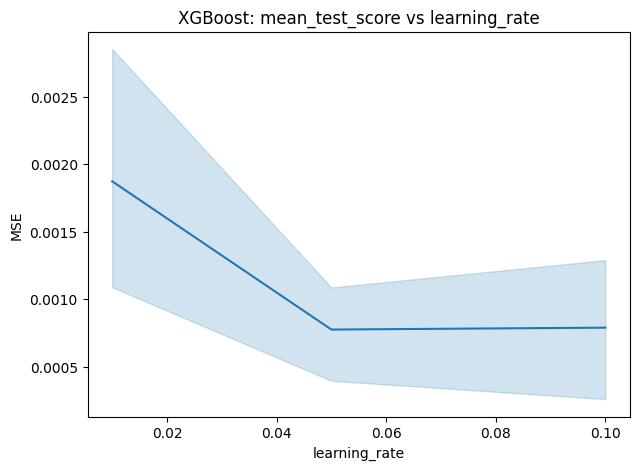

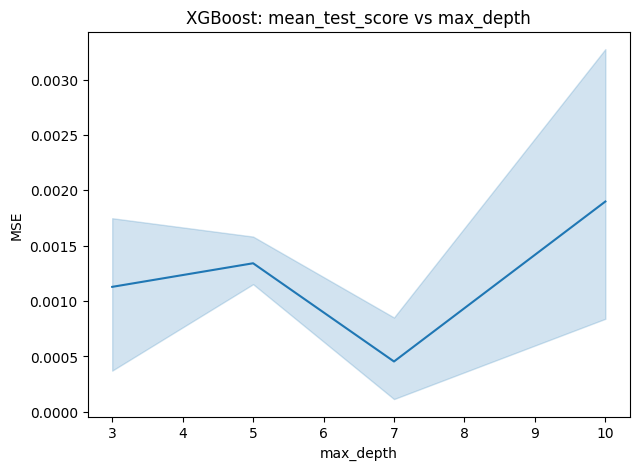

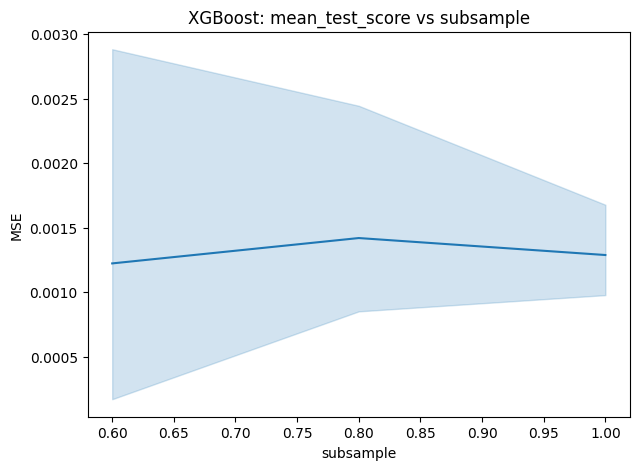

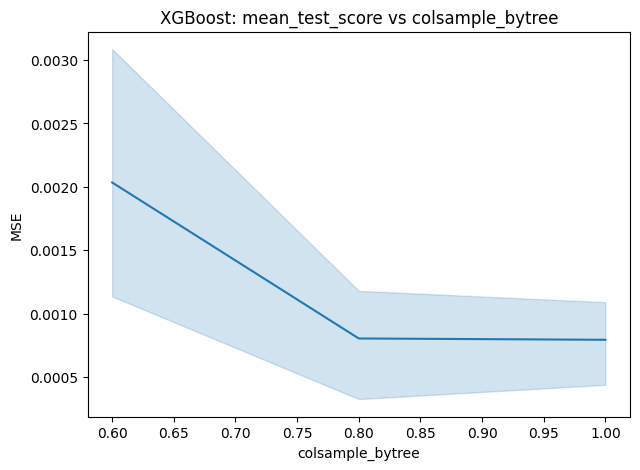

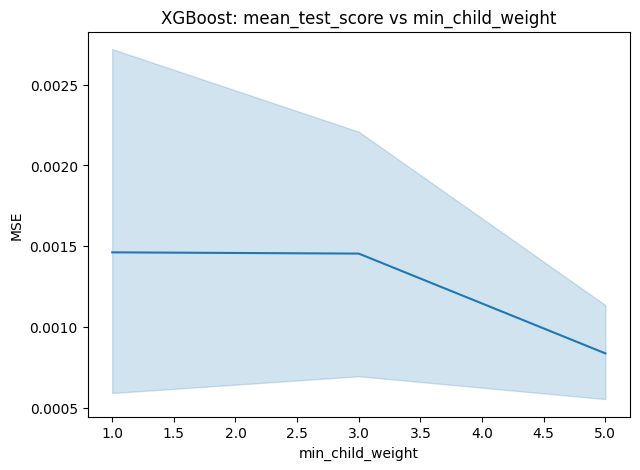

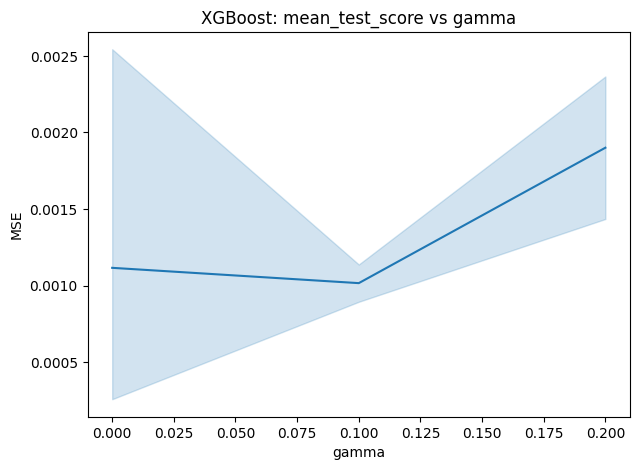

In [ ]:
for param in xgb_params.keys():
  if param != "hidden_layer_sizes": # Cannot plot hidden_layer_sizes directly
    plot_search_results(xgb_search, "XGBoost", param_x=param)

Hyperparameter Tuning for Minute-level Data

In [ ]:
# Tuning MLP and XGBoost on sample data (minute-level)
# This is due to the scale of the minute-level data.
# Using a representative subsample is more computationally efficient.

mlp_param_grid = {
    "hidden_layer_sizes": [(50,), (100,), (100, 50), (200, 100)],
    "activation": ["relu", "tanh"],
    "solver": ["adam"],
    "alpha": [1e-4, 1e-3, 1e-2],
    "learning_rate_init": [0.001, 0.01, 0.05],
    "max_iter": [100]  # keep small for tuning speed
}

xgb_param_grid = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [3, 5, 7],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.7, 0.8, 1.0]
}

In [ ]:
# Randomized Search on subsample

print("\nTuning MLP on 10% of minute-level data...")
mlp_sample = MLPRegressor(random_state=42)
mlp_search_sample = RandomizedSearchCV(
    mlp_sample,
    mlp_param_grid,
    n_iter=10,  # number of random combinations
    scoring="neg_mean_squared_error",
    cv=3,
    n_jobs=-1,
    verbose=2,
    random_state=42
)
mlp_search_sample.fit(X_min_sub, y_min_sub)
print("Best MLP params:", mlp_search_sample.best_params_)

print("\nTuning XGBoost on 10% of minute-level data...")
xgb_reg_sample = xgb.XGBRegressor(random_state=42, n_jobs=-1)
xgb_search_sample = RandomizedSearchCV(
    xgb_reg_sample,
    xgb_param_grid,
    n_iter=10,
    scoring="neg_mean_squared_error",
    cv=3,
    n_jobs=-1,
    verbose=2,
    random_state=42
)
xgb_search_sample.fit(X_min_sub, y_min_sub)
print("Best XGBoost params:", xgb_search_sample.best_params_)


Tuning MLP on 10% of minute-level data...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best MLP params: {'solver': 'adam', 'max_iter': 100, 'learning_rate_init': 0.01, 'hidden_layer_sizes': (100,), 'alpha': 0.0001, 'activation': 'relu'}

Tuning XGBoost on 10% of minute-level data...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best XGBoost params: {'subsample': 0.8, 'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 1.0}


In [ ]:
# Retrain best models on full dataset

print("\nRetraining best MLP on full minute-level data...")
mlp_best = MLPRegressor(**mlp_search_sample.best_params_, random_state=42)
start_time = time.time()
mlp_best.fit(X_min_train, y_min_train)
mlp_pred = mlp_best.predict(X_min_test)
end_time = time.time()
mlp_time = end_time - start_time
results_tuned.append(evaluate_model(y_min_test, mlp_pred, "MLP (Tuned)", "Minute", mlp_time))

print("\nRetraining best XGBoost on full minute-level data...")
xgb_best = xgb.XGBRegressor(**xgb_search_sample.best_params_, random_state=42, n_jobs=-1)
start_time = time.time()
xgb_best.fit(X_min_train, y_min_train)
xgb_pred = xgb_best.predict(X_min_test)
end_time = time.time()
xgb_time = end_time - start_time
results_tuned.append(evaluate_model(y_min_test, xgb_pred, "XGBoost (Tuned)", "Minute", xgb_time))


Retraining best MLP on full minute-level data...

MLP (Tuned) (Minute) Results:
MSE: 0.0336
MAE: 0.1506
RMSE: 0.1834
R2 Score: -0.0308
Execution Time: 156.9387 seconds

Retraining best XGBoost on full minute-level data...

XGBoost (Tuned) (Minute) Results:
MSE: 0.0000
MAE: 0.0040
RMSE: 0.0065
R2 Score: 0.9987
Execution Time: 11.6988 seconds


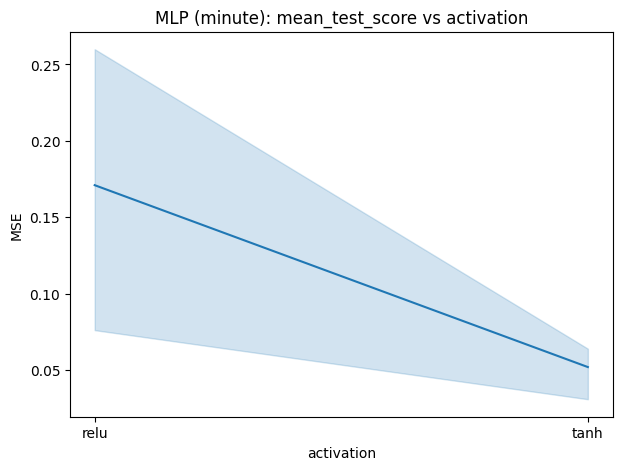

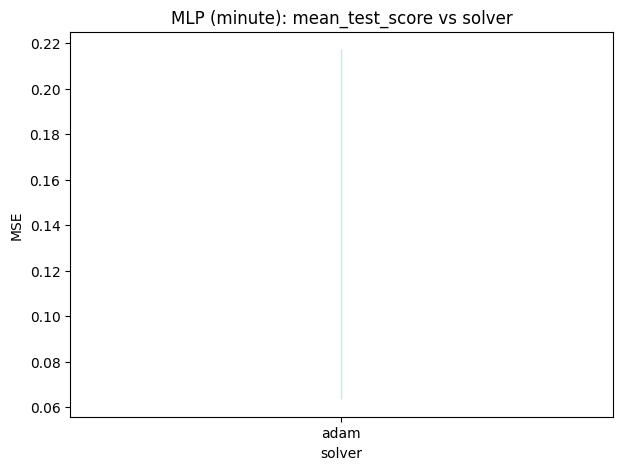

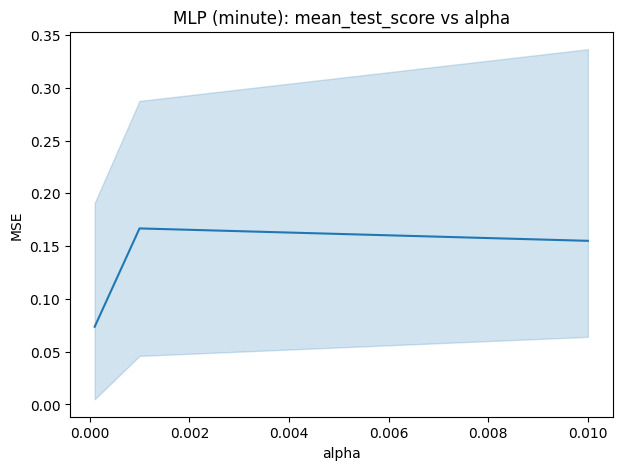

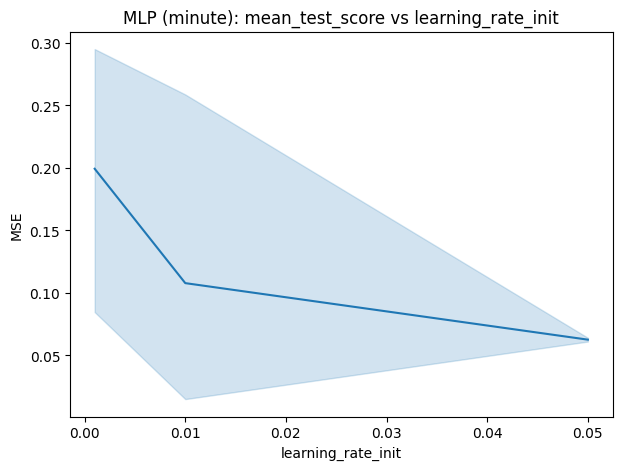

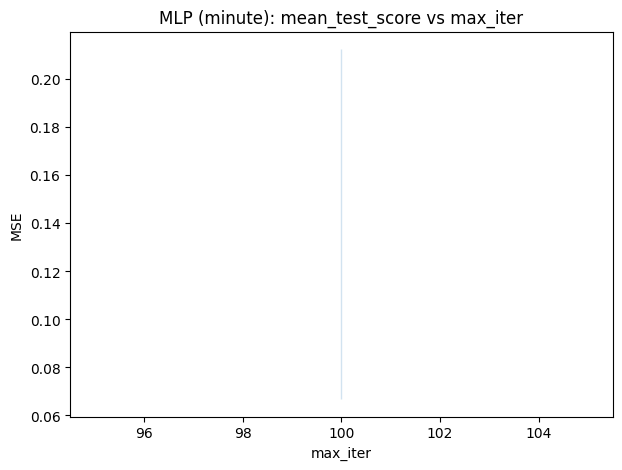

In [ ]:
for param in mlp_param_grid.keys():
  if param != "hidden_layer_sizes": # Cannot plot hidden_layer_sizes directly
    plot_search_results(mlp_search_sample, "MLP (minute)", param_x=param)

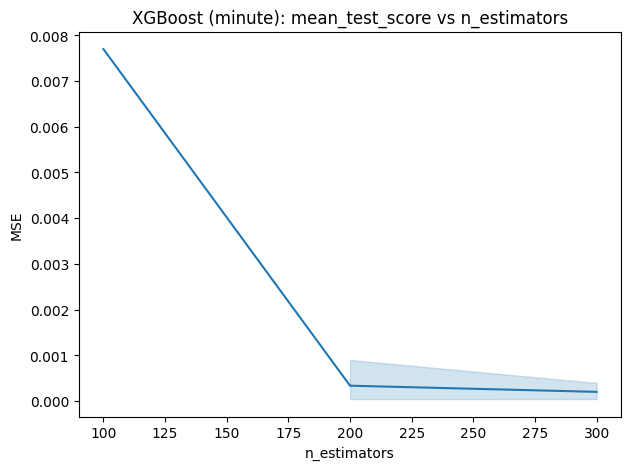

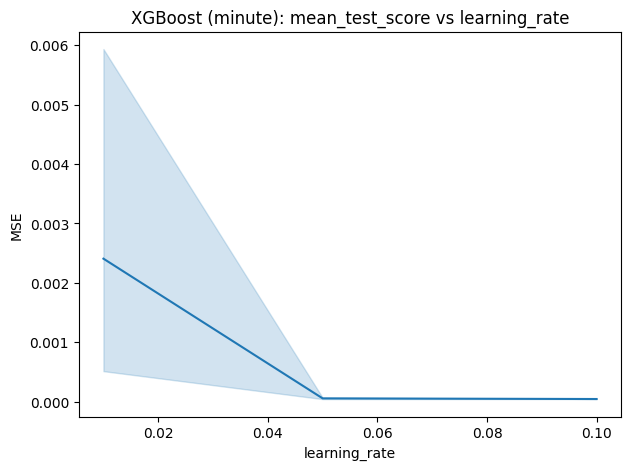

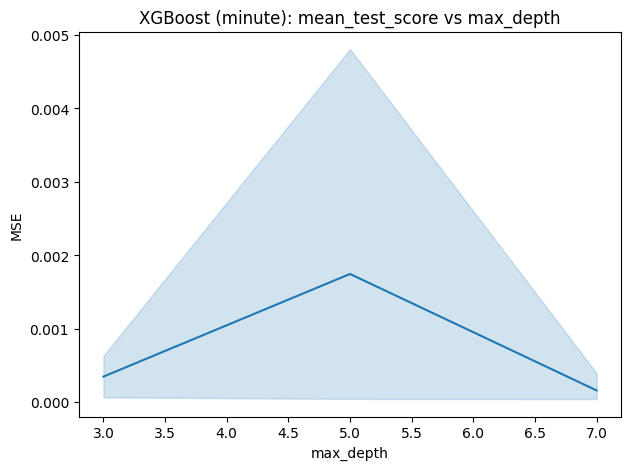

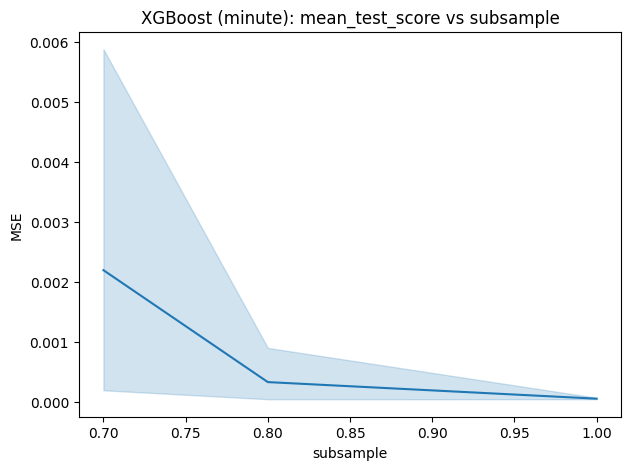

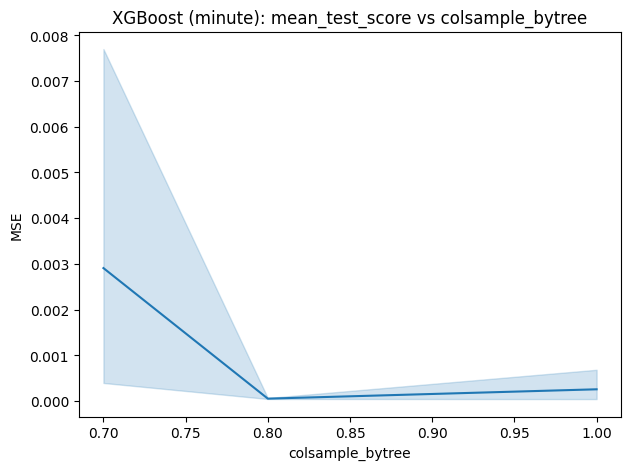

In [ ]:
for param in xgb_param_grid.keys():
  if param != "hidden_layer_sizes": # Cannot plot hidden_layer_sizes directly
    plot_search_results(xgb_search_sample, "XGBoost (minute)", param_x=param)

**Comparison of results**

In [ ]:
results_tuned_df = pd.DataFrame(results_tuned)
print("Comparisons of Tuned Models: \n")
print(results_tuned_df)

Comparisons of Tuned Models: 

             Model Frequency       MSE       MAE      RMSE        R2  \
0      MLP (Tuned)    Minute  0.033618  0.150631  0.183352 -0.030784   
1  XGBoost (Tuned)    Minute  0.000042  0.004034  0.006493  0.998707   
2      MLP (Tuned)    Hourly  0.004374  0.058162  0.066134  0.811645   
3      SVM (Tuned)    Hourly  0.000076  0.006065  0.008739  0.996711   
4  XGBoost (Tuned)    Hourly  0.000038  0.003682  0.006151  0.998371   
5      MLP (Tuned)     Daily  0.011671  0.084329  0.108033 -0.141354   
6      SVM (Tuned)     Daily  0.004472  0.048846  0.066874  0.562659   
7  XGBoost (Tuned)     Daily  0.000022  0.003555  0.004653  0.997882   

   Execution Time  
0      156.938718  
1       11.698790  
2       22.814832  
3      133.475934  
4        9.601167  
5        4.587692  
6        1.076323  
7        3.804999  


# Visualisations

In [ ]:
results_df

,Model,Frequency,MSE,MAE,RMSE,R2,Execution Time
0,MLP,Minute,0.000148,0.009373,0.012168,0.995460,1283.377436
1,XGBoost,Minute,0.000045,0.004290,0.006675,0.998634,7.961397
2,MLP,Hourly,0.070648,0.261934,0.265797,-2.042489,3.097425
3,SVM,Hourly,0.009522,0.080302,0.097582,0.589918,21.117358
4,XGBoost,Hourly,0.000029,0.003286,0.005355,0.998765,1.761880
5,MLP,Daily,0.016902,0.104482,0.130006,-0.652857,1.413915
6,SVM,Daily,0.010594,0.079656,0.102927,-0.036011,0.863598
7,XGBoost,Daily,0.000033,0.004194,0.005705,0.996818,1.178888


In [ ]:
results_tuned_df

,Model,Frequency,MSE,MAE,RMSE,R2,Execution Time
0,MLP (Tuned),Minute,0.033618,0.150631,0.183352,-0.030784,156.938718
1,XGBoost (Tuned),Minute,0.000042,0.004034,0.006493,0.998707,11.698790
2,MLP (Tuned),Hourly,0.004374,0.058162,0.066134,0.811645,22.814832
3,SVM (Tuned),Hourly,0.000076,0.006065,0.008739,0.996711,133.475934
4,XGBoost (Tuned),Hourly,0.000038,0.003682,0.006151,0.998371,9.601167
5,MLP (Tuned),Daily,0.011671,0.084329,0.108033,-0.141354,4.587692
6,SVM (Tuned),Daily,0.004472,0.048846,0.066874,0.562659,1.076323
7,XGBoost (Tuned),Daily,0.000022,0.003555,0.004653,0.997882,3.804999


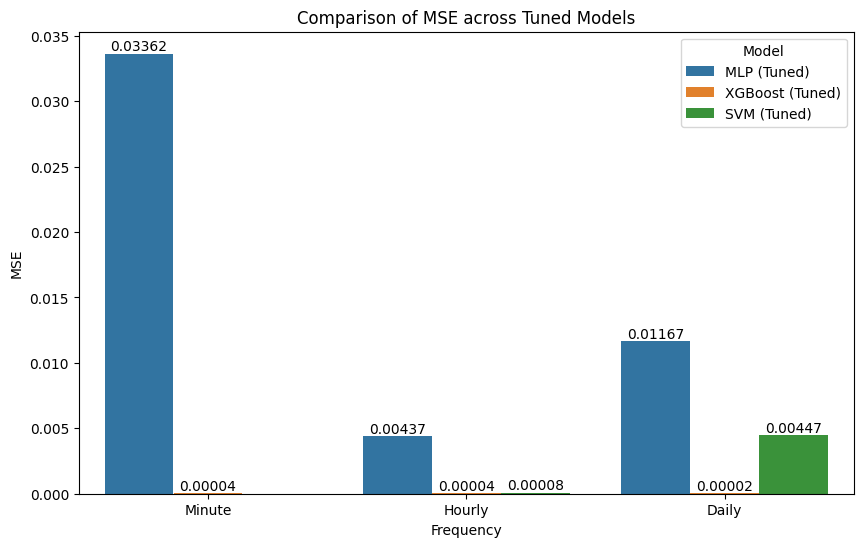

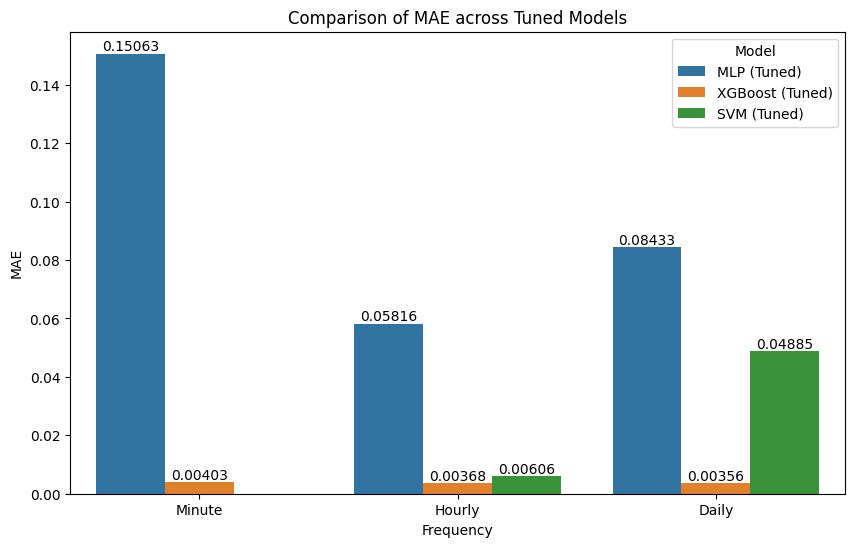

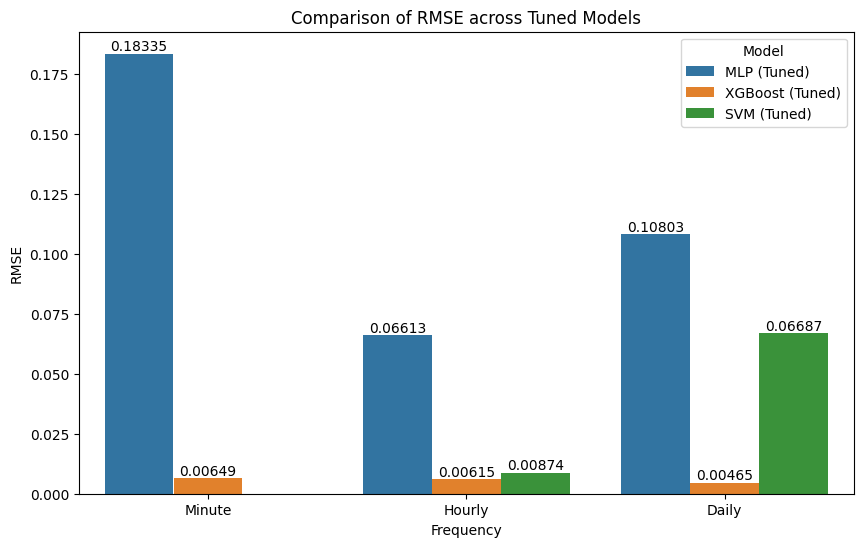

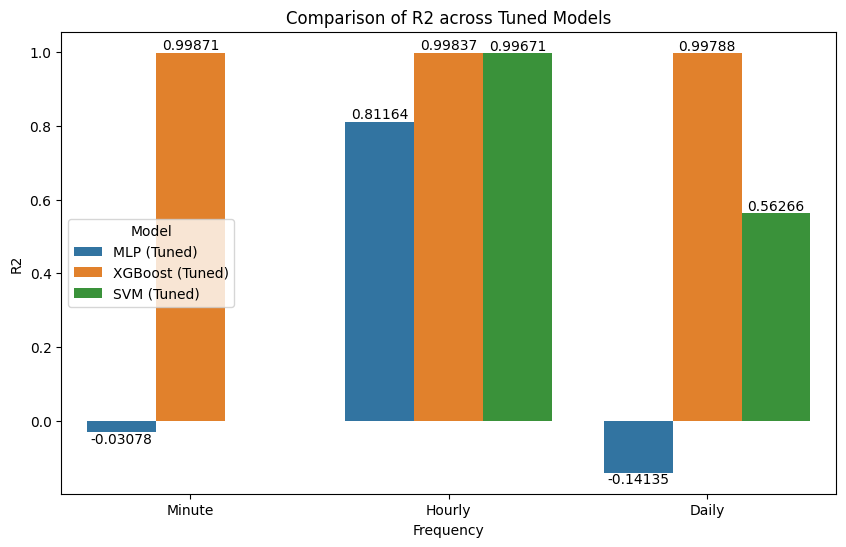

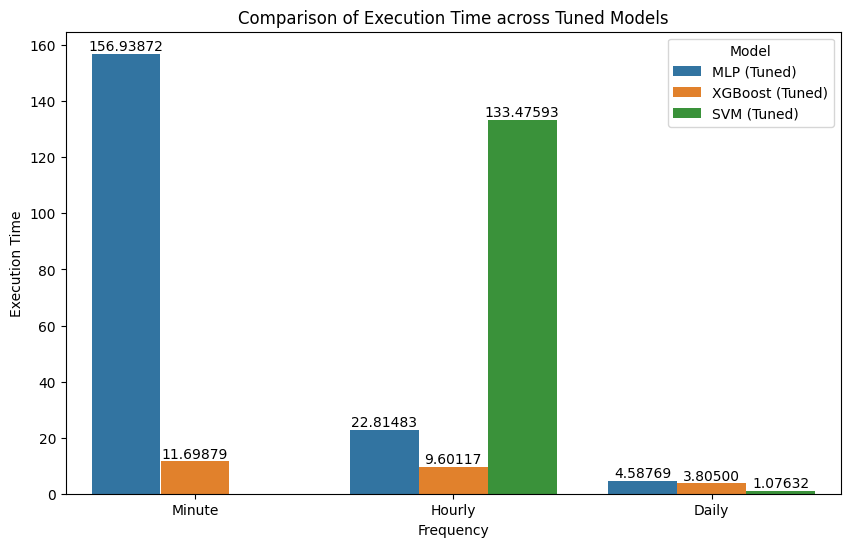

In [ ]:
# Bar Plots of metrics across tuned models

metrics_col = ["MSE", "MAE", "RMSE", "R2", "Execution Time"]
for col in metrics_col:
  plt.figure(figsize=(10,6))
  ax = sns.barplot(data=results_tuned_df, x="Frequency", y=col, hue="Model")
  plt.title(f"Comparison of {col} across Tuned Models")
  plt.xlabel("Frequency")
  plt.ylabel(col)

  # Add values on top of the bars
  for container in ax.containers:
      ax.bar_label(container, fmt='%.5f')

  plt.show()

In [ ]:
# Comparing tuned vs untuned

results_tuned_df["Model"] = results_tuned_df["Model"].replace({"MLP (Tuned)": "MLP", "SVM (Tuned)": "SVM", "XGBoost (Tuned)": "XGBoost"})
results_tuned_df

,Model,Frequency,MSE,MAE,RMSE,R2,Execution Time
0,MLP,Minute,0.033618,0.150631,0.183352,-0.030784,156.938718
1,XGBoost,Minute,0.000042,0.004034,0.006493,0.998707,11.698790
2,MLP,Hourly,0.004374,0.058162,0.066134,0.811645,22.814832
3,SVM,Hourly,0.000076,0.006065,0.008739,0.996711,133.475934
4,XGBoost,Hourly,0.000038,0.003682,0.006151,0.998371,9.601167
5,MLP,Daily,0.011671,0.084329,0.108033,-0.141354,4.587692
6,SVM,Daily,0.004472,0.048846,0.066874,0.562659,1.076323
7,XGBoost,Daily,0.000022,0.003555,0.004653,0.997882,3.804999


In [ ]:
results_tuned_df['Status'] = "Tuned"
results_df['Status'] = "Untuned"

In [ ]:
df_compare = pd.concat([results_df, results_tuned_df], ignore_index=True)
df_compare

,Model,Frequency,MSE,MAE,RMSE,R2,Execution Time,Status
0,MLP,Minute,0.000148,0.009373,0.012168,0.995460,1283.377436,Untuned
1,XGBoost,Minute,0.000045,0.004290,0.006675,0.998634,7.961397,Untuned
2,MLP,Hourly,0.070648,0.261934,0.265797,-2.042489,3.097425,Untuned
3,SVM,Hourly,0.009522,0.080302,0.097582,0.589918,21.117358,Untuned
4,XGBoost,Hourly,0.000029,0.003286,0.005355,0.998765,1.761880,Untuned
5,MLP,Daily,0.016902,0.104482,0.130006,-0.652857,1.413915,Untuned
6,SVM,Daily,0.010594,0.079656,0.102927,-0.036011,0.863598,Untuned
7,XGBoost,Daily,0.000033,0.004194,0.005705,0.996818,1.178888,Untuned
8,MLP,Minute,0.033618,0.150631,0.183352,-0.030784,156.938718,Tuned
9,XGBoost,Minute,0.000042,0.004034,0.006493,0.998707,11.698790,Tuned


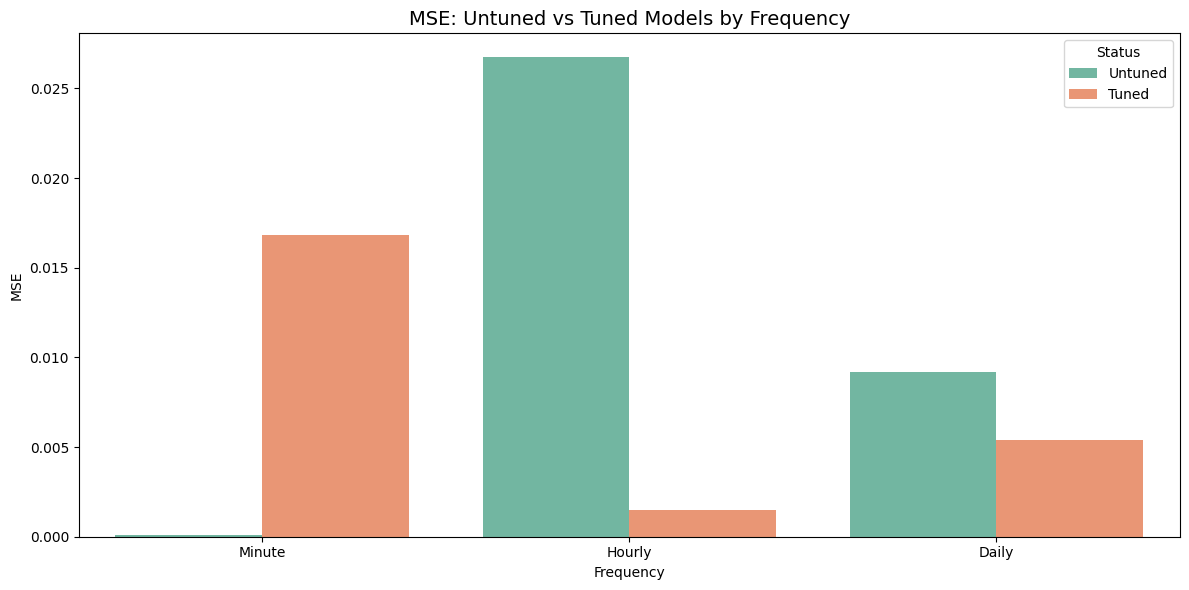

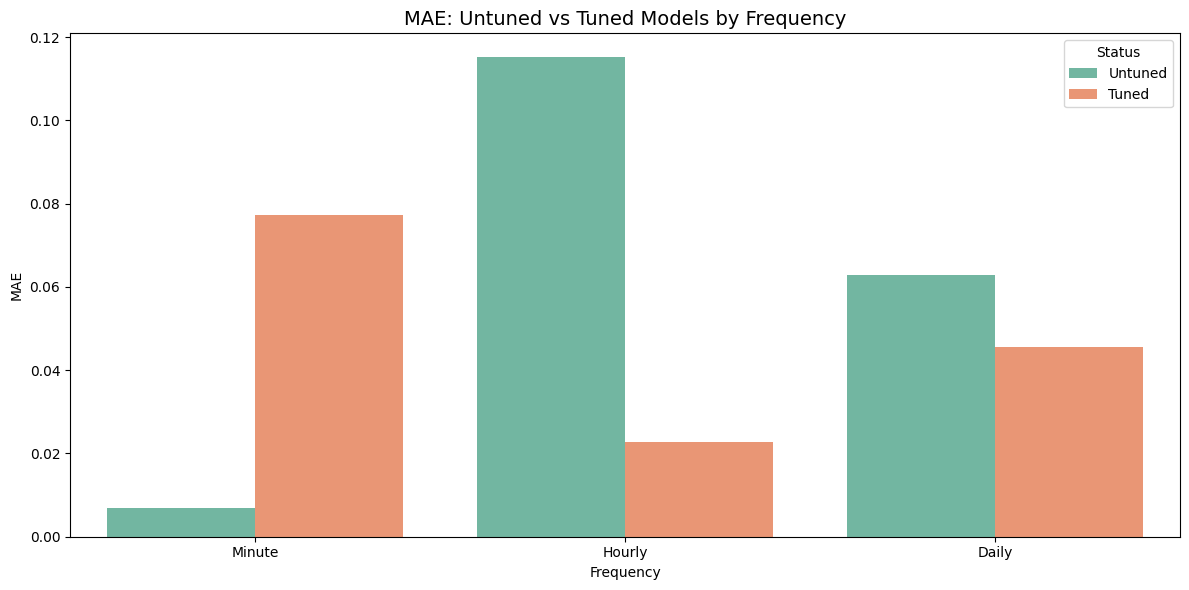

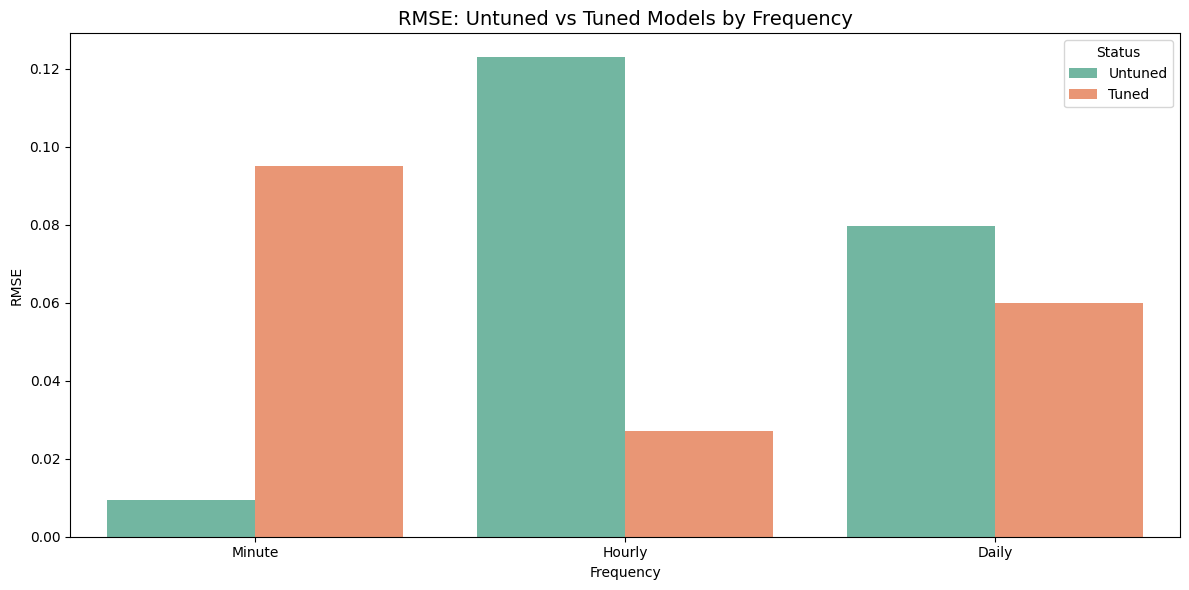

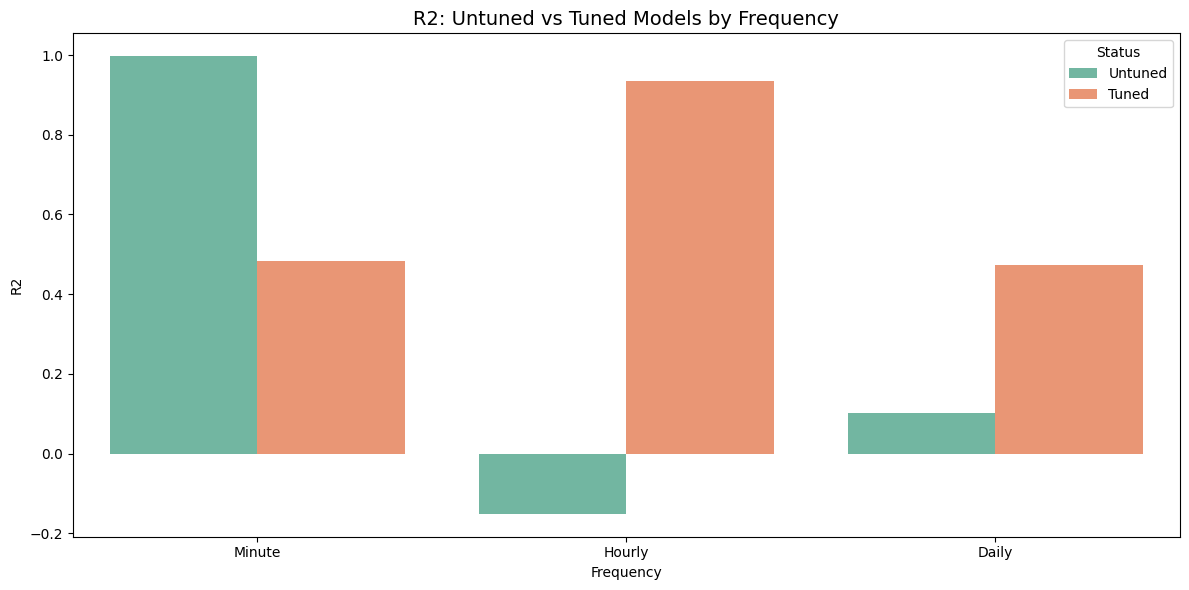

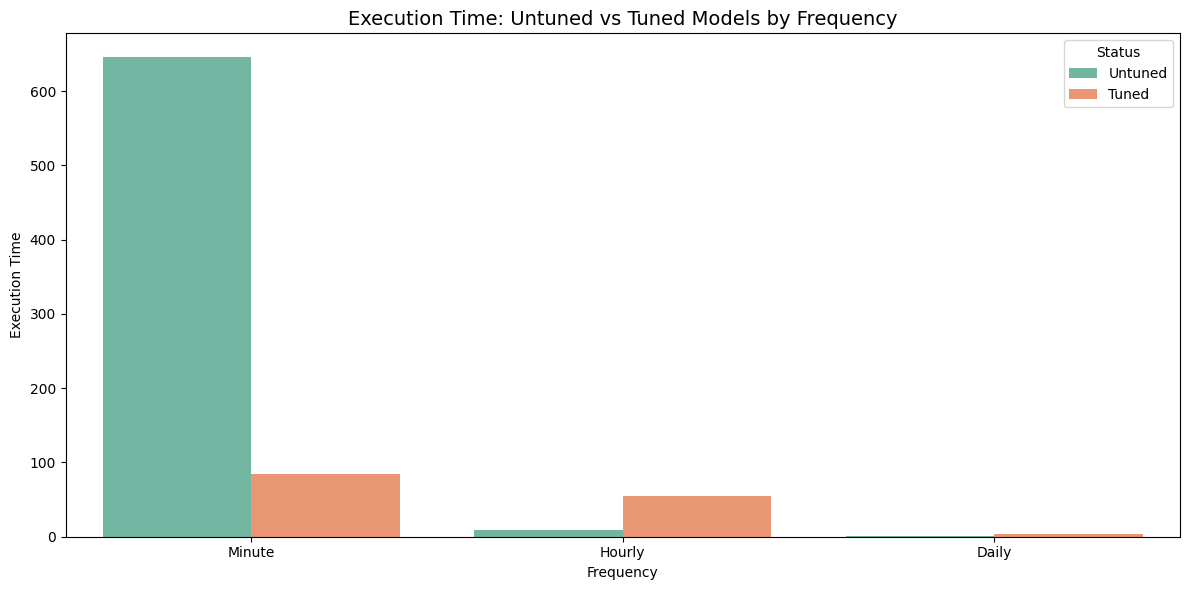

In [ ]:
# Grouped bar charts

for metric in metrics_col:
    plt.figure(figsize=(12,6))
    sns.barplot(
        data=df_compare,
        x="Frequency",
        y=metric,
        hue="Status",
        palette="Set2",
        ci=None
    )
    plt.title(f"{metric}: Untuned vs Tuned Models by Frequency", fontsize=14)
    plt.ylabel(metric)
    plt.xlabel("Frequency")
    plt.legend(title="Status")
    plt.tight_layout()
    plt.show()

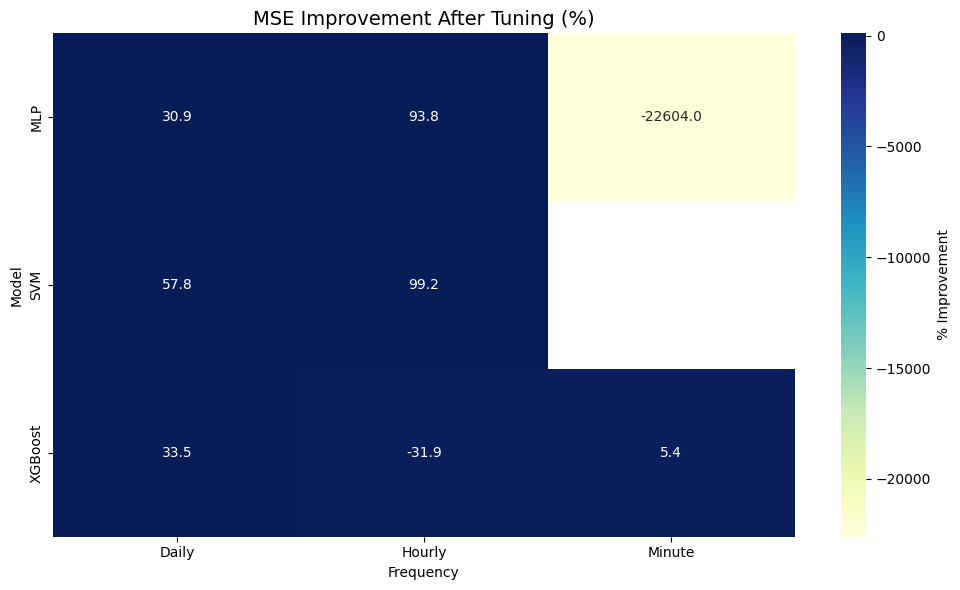

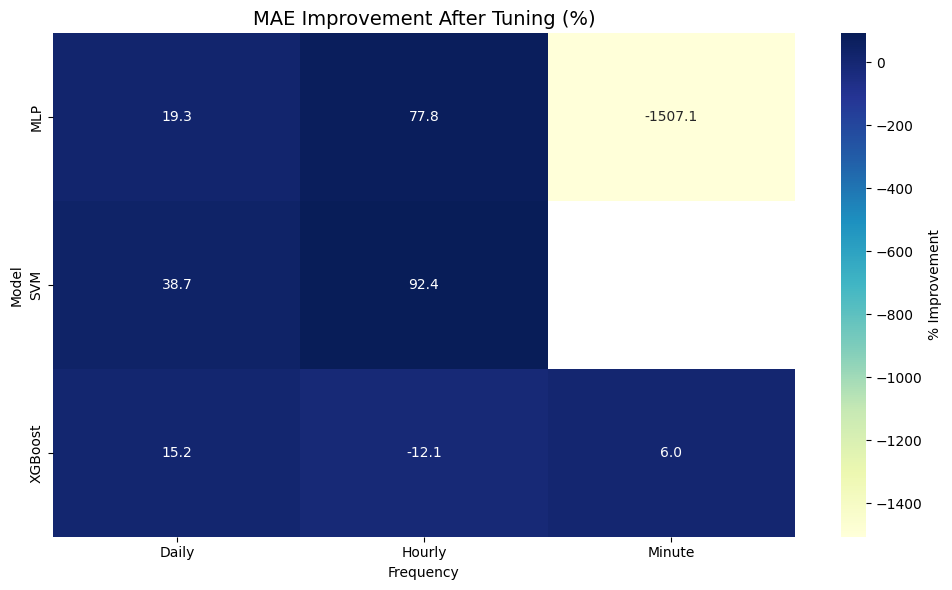

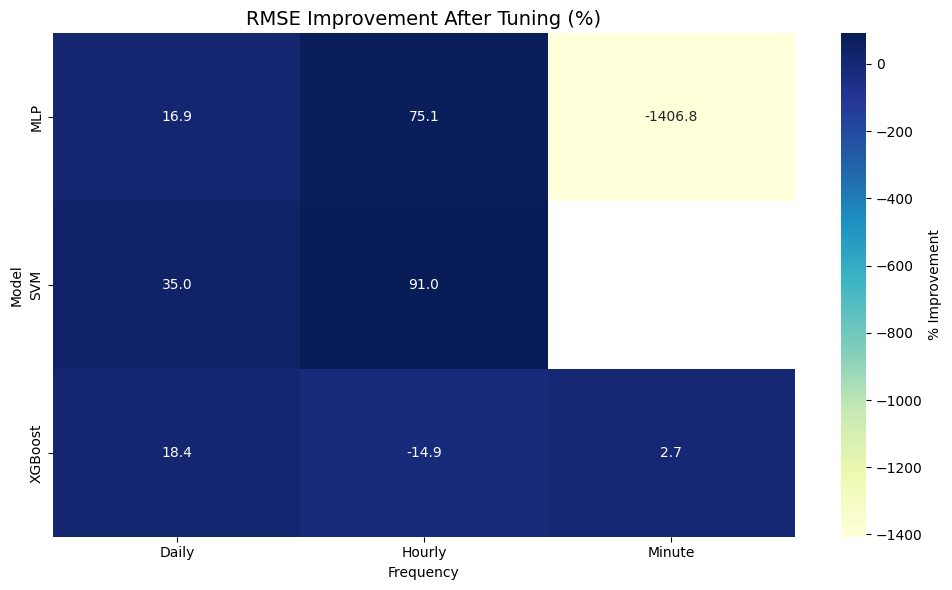

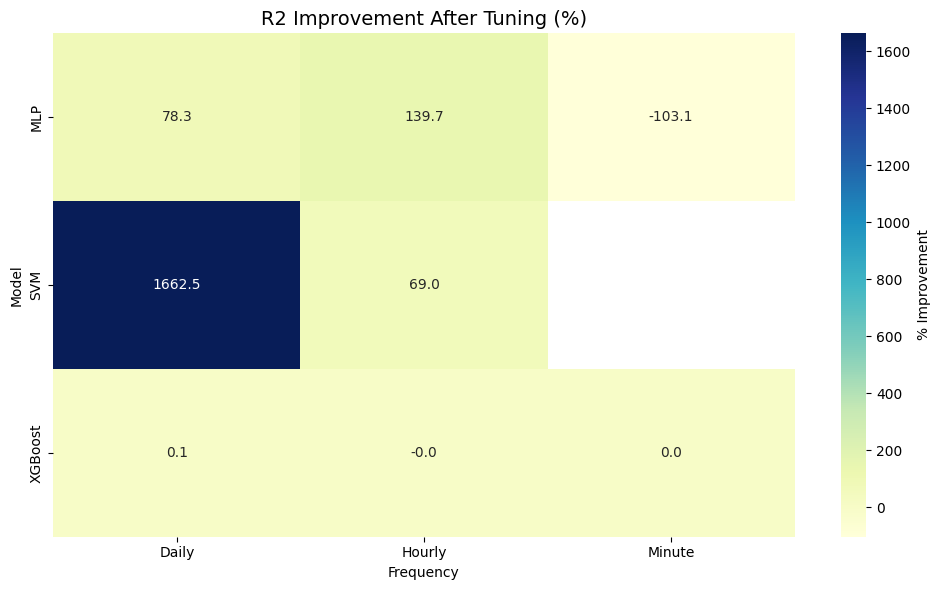

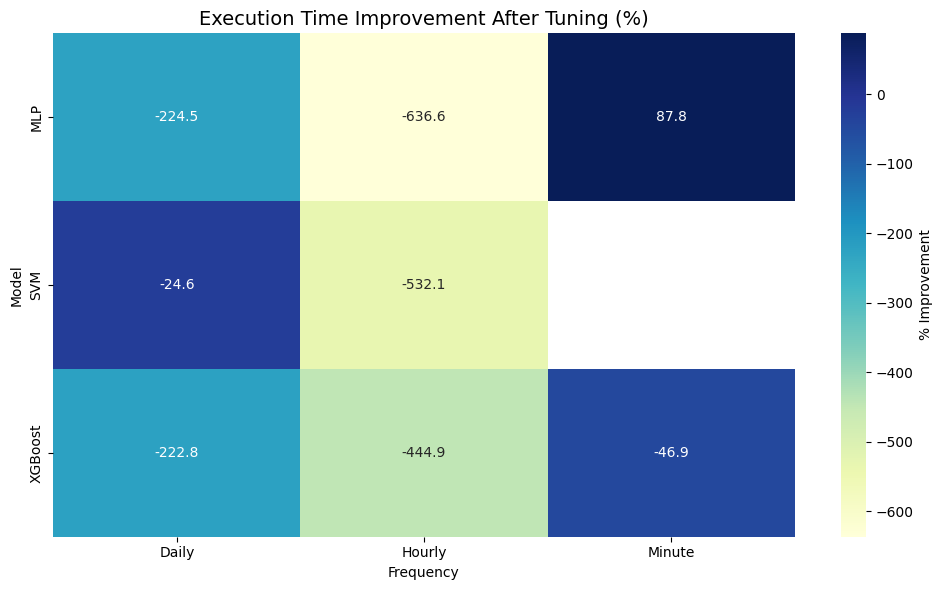

In [ ]:
# Heatmaps of % Improvement -- was coded with the help of Gemini AI
# First pivot: merge tuned + untuned
df_untuned = df_compare[df_compare["Status"]=="Untuned"].drop(columns="Status")
df_tuned   = df_compare[df_compare["Status"]=="Tuned"].drop(columns="Status")

merged = df_untuned.merge(df_tuned, on=["Model","Frequency"], suffixes=("_untuned","_tuned"))

for metric in metrics_col:
    if metric == "Execution Time":
        # For execution time, lower is better → improvement = (untuned - tuned)/untuned
        merged[f"{metric}_Improvement(%)"] = 100 * (merged[f"{metric}_untuned"] - merged[f"{metric}_tuned"]) / merged[f"{metric}_untuned"]
    else:
        # For error metrics (MSE, MAE, RMSE), lower is better
        # For R2, higher is better → reverse the formula
        if metric == "R2":
            merged[f"{metric}_Improvement(%)"] = 100 * (merged[f"{metric}_tuned"] - merged[f"{metric}_untuned"]) / abs(merged[f"{metric}_untuned"])
        else:
            merged[f"{metric}_Improvement(%)"] = 100 * (merged[f"{metric}_untuned"] - merged[f"{metric}_tuned"]) / merged[f"{metric}_untuned"]

    pivot = merged.pivot(index="Model", columns="Frequency", values=f"{metric}_Improvement(%)")

    plt.figure(figsize=(10,6))
    sns.heatmap(pivot, annot=True, fmt=".1f", cmap="YlGnBu", cbar_kws={'label': '% Improvement'})
    plt.title(f"{metric} Improvement After Tuning (%)", fontsize=14)
    plt.xlabel("Frequency")
    plt.ylabel("Model")
    plt.tight_layout()
    plt.show()